In [2]:
import io
import cv2
import json
import os 
import numpy as np
from PIL import Image
from pathlib import Path
from google.cloud import vision
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,8)
    

In [3]:
# Set your working paths
BASE_DIR = Path("../data")
SAMPLES_DIR = BASE_DIR / "samples"
IMAGE_PATH = SAMPLES_DIR / "test_sentence_devanagari.png"

# Path for saving outputs
OUTPUT_JSON = Path("../logs/ocr_output.json")
OUTPUT_IMAGE = Path("../logs/ocr_boxes_preview.jpg")

# Set Google credentials (update the path to your service account key JSON)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/jyotirmoy/Desktop/ancient-script-ai-f183c67eebe5.json"

print(f"📜 Image loaded from: {IMAGE_PATH}")


📜 Image loaded from: ../data/samples/test_sentence_devanagari.png


In [4]:
def preprocess_image(image_path):
    """Preprocess image for OCR clarity: grayscale, contrast, denoise."""
    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f"❌ Image not found: {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.fastNlMeansDenoising(gray, h=25)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    processed_path = Path("temp_preprocessed.png")
    cv2.imwrite(str(processed_path), enhanced)
    return processed_path


In [5]:
def extract_text_with_bboxes(image_path):
    """Extract structured OCR text and bounding boxes."""
    client = vision.ImageAnnotatorClient()

    processed_path = preprocess_image(image_path)

    with io.open(processed_path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)
    response = client.document_text_detection(image=image)

    if response.error.message:
        raise Exception(f"⚠️ Google Vision Error: {response.error.message}")

    results = {
        "full_text": response.full_text_annotation.text.strip(),
        "blocks": []
    }

    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            text_content = ""
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    text_content += "".join([s.text for s in word.symbols]) + " "
            bbox = [(v.x, v.y) for v in block.bounding_box.vertices]
            results["blocks"].append({
                "text": text_content.strip(),
                "bbox": bbox
            })

    return results


In [6]:
print(" Performing OCR on Sanskrit manuscript...")
result = extract_text_with_bboxes(IMAGE_PATH)

print("\n✅ Extracted Text:")
print(result["full_text"][:800], "...\n")  # print sample

# Save structured JSON
with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

print(f"📁 Structured OCR JSON saved at: {OUTPUT_JSON.resolve()}")


🕉️ Performing OCR on Sanskrit manuscript...

✅ Extracted Text:
॥श्रीगणेशायनमः)॥ अथरात्रिसूक्तं " "
रात्रीव्यख्यदाय ती पुरुत्रादेव्य१क्षभिः॥विश्वा
अधिश्रियेोधित॥ और्व प्रो. अमत्या निवतो
देव्यु द्दितः ॥ ज्योतिषा बाधते नमः निरुखसार
मरछतोष संदेव्यायुती ॥ अपेदु॒हासते तमः ॥
साना॒ अद्ययस्याव॒यं नित्यामन वि॑िक्ष्महि ॥ वृ
क्षेत्र वसतिं वयः॥निया मासो अविक्षत् नि ...

📁 Structured OCR JSON saved at: /Users/jyotirmoy/Desktop/Image/ancient-script-ai/logs/ocr_output.json


🟩 Bounding boxes image saved to: ../logs/ocr_boxes_preview.jpg


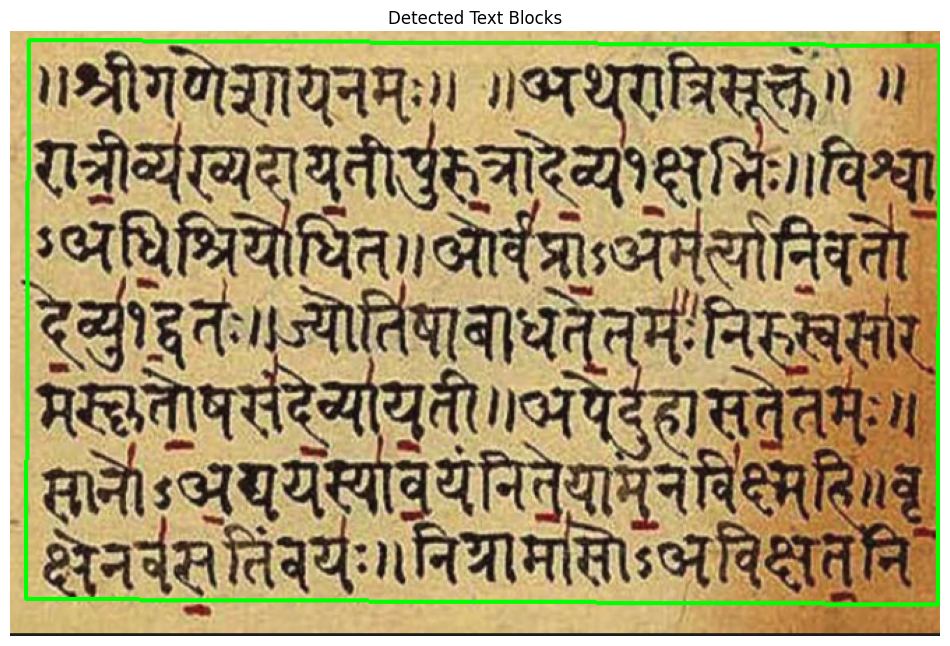

In [7]:
def visualize_bboxes(image_path, blocks, save_path):
    """Draw bounding boxes on image for visualization."""
    img = cv2.imread(str(image_path))
    for b in blocks:
        pts = np.array(b["bbox"], np.int32).reshape((-1, 1, 2))
        cv2.polylines(img, [pts], True, (0, 255, 0), 2)

    cv2.imwrite(str(save_path), img)
    print(f"🟩 Bounding boxes image saved to: {save_path}")

    # Display inline
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Text Blocks")
    plt.axis("off")
    plt.show()

visualize_bboxes(IMAGE_PATH, result["blocks"], OUTPUT_IMAGE)


In [8]:
# Optional: save the extracted plain text for translation model input
plain_text_path = Path("../logs/ocr_extracted_text.txt")
with open(plain_text_path, "w", encoding="utf-8") as f:
    f.write(result["full_text"])

print(f"📜 Clean text saved to: {plain_text_path.resolve()}")


📜 Clean text saved to: /Users/jyotirmoy/Desktop/Image/ancient-script-ai/logs/ocr_extracted_text.txt
